In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

In [3]:
pen = pd.read_csv("data/penguins.csv").dropna()
Y = pen["body_mass"]
pen['sex'].replace(['male', 'female'],[0, 1], inplace=True)
pen['species'].replace(['Adelie', 'Chinstrap', 'Gentoo'],[0, 1, 2], inplace=True)
X = pen[["flipper_length", "bill_depth", "bill_length"]]

In [4]:
with pm.Model() as model_pen:
    σ = pm.HalfNormal("σ", 1)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=Y)
    idata_pen = pm.sample(random_seed=123)
    pm.sample_posterior_predictive(idata_pen, extend_inferencedata=True, random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


In [5]:
idata_pen.posterior_predictive.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    y        float64 1.752

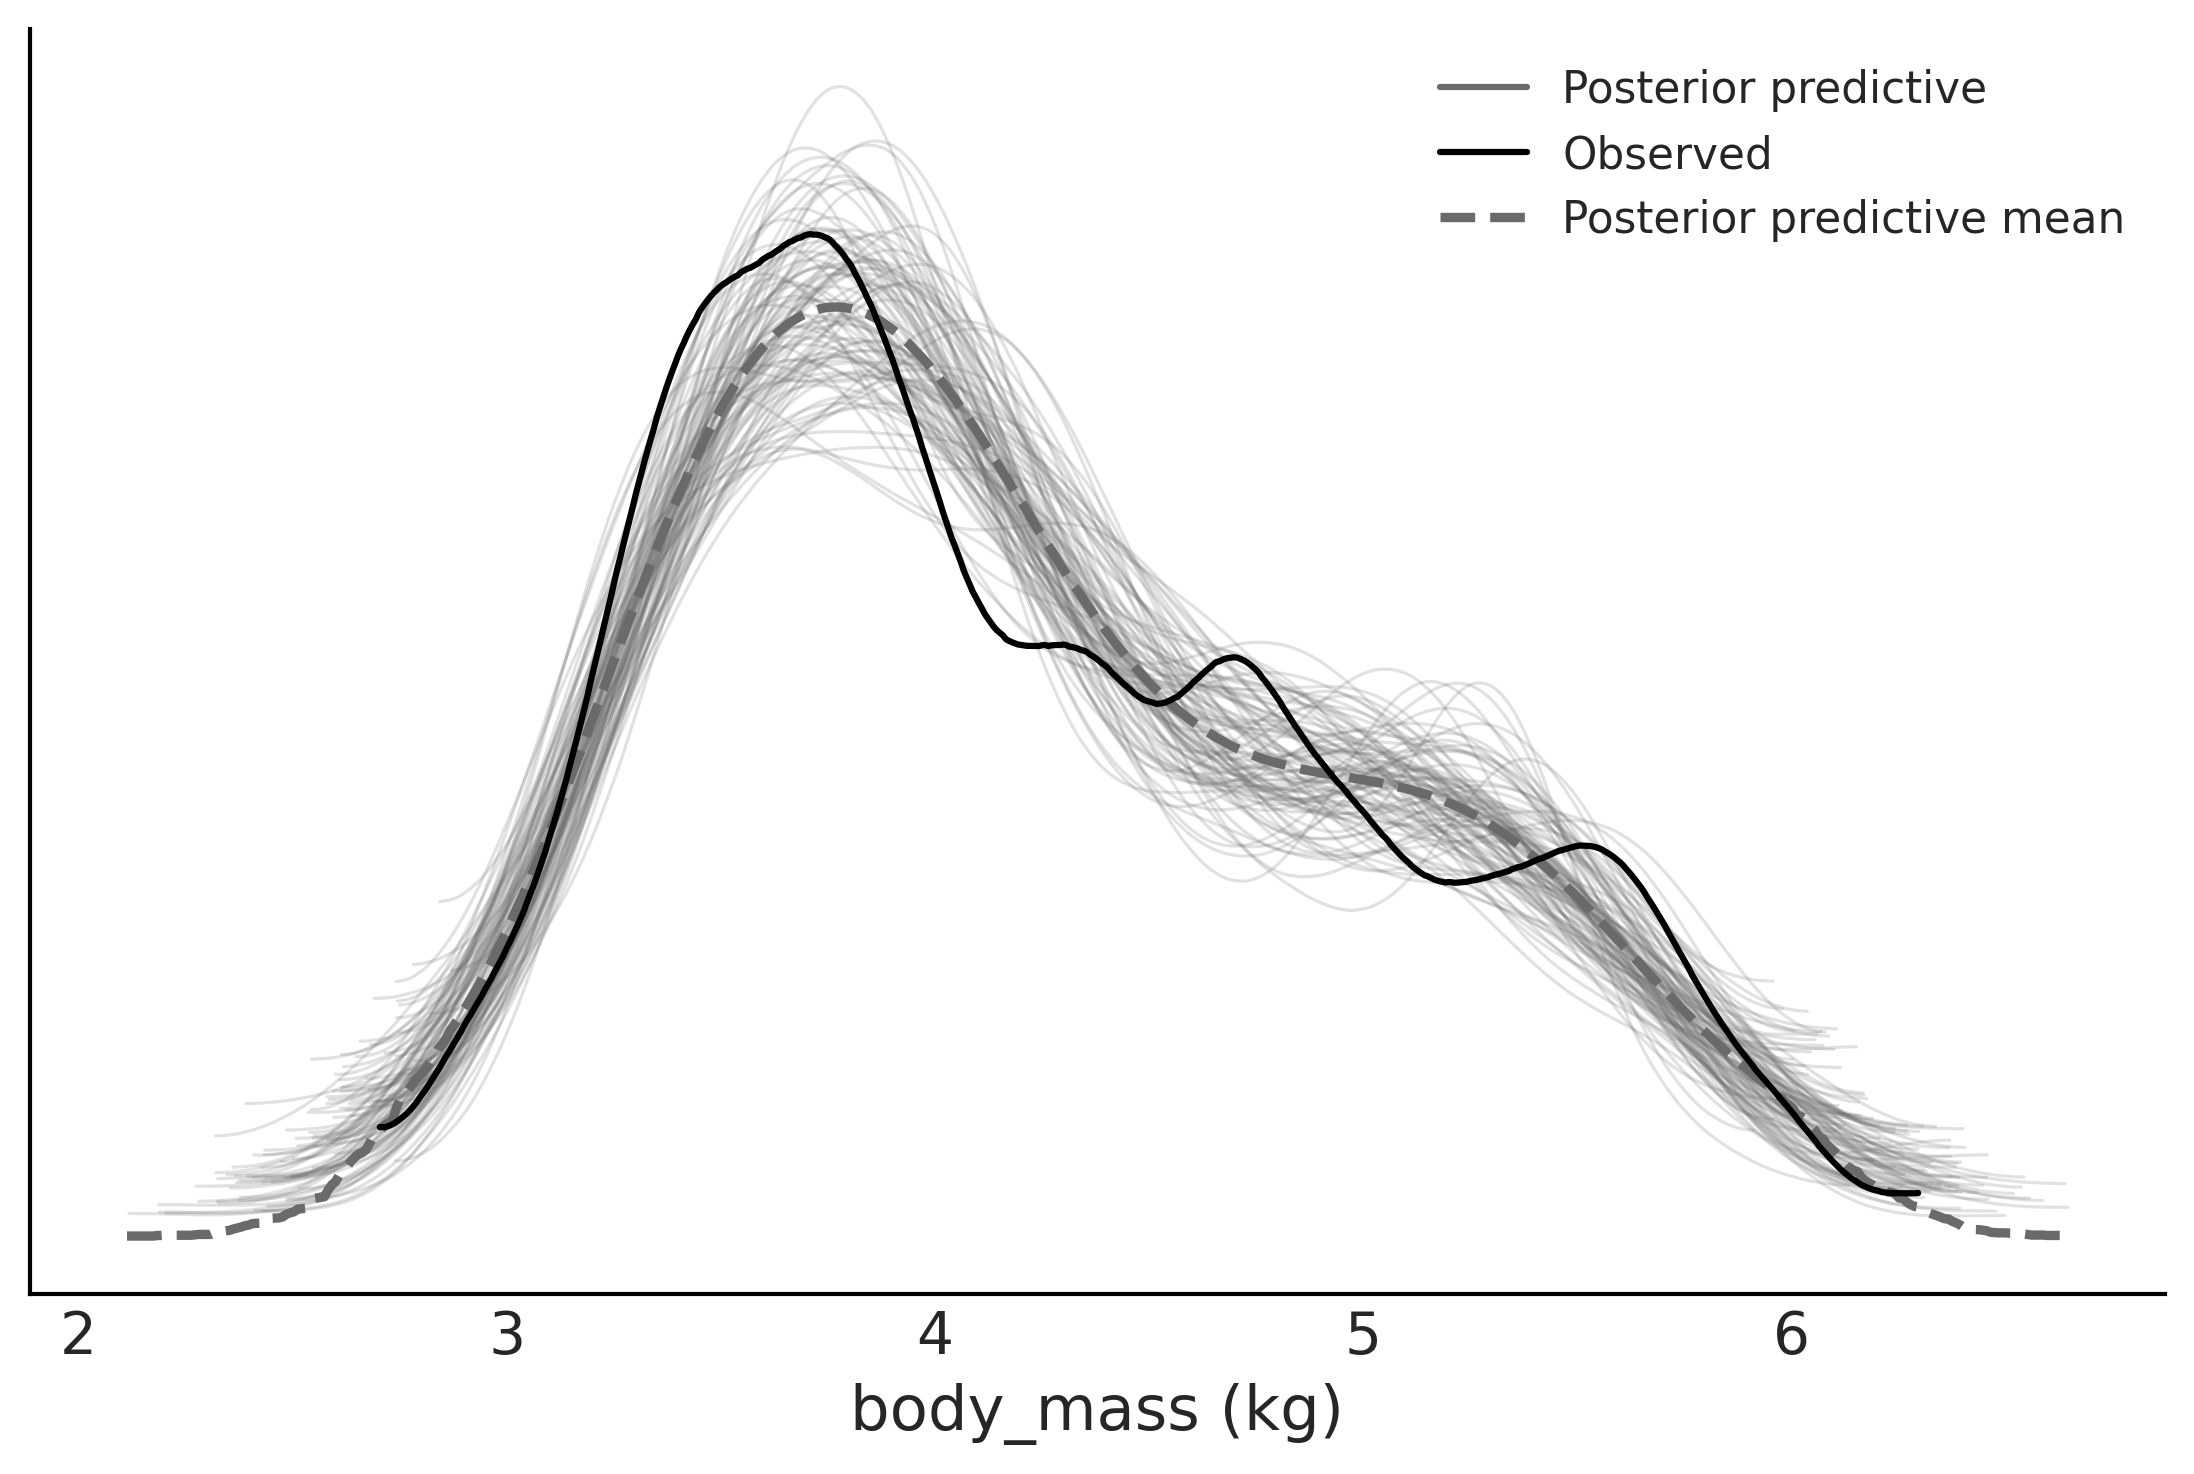

In [6]:
ax = az.plot_ppc(idata_pen, num_pp_samples=100, colors=["C1", "C0", "C1"])
ax.set_xlabel("body_mass (kg)")
plt.savefig("../fig/BART_ppc.png")

In [7]:
az.summary(idata_pen, var_names=["~μ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,0.336,0.015,0.307,0.365,0.0,0.0,1124.0,2164.0,1.0


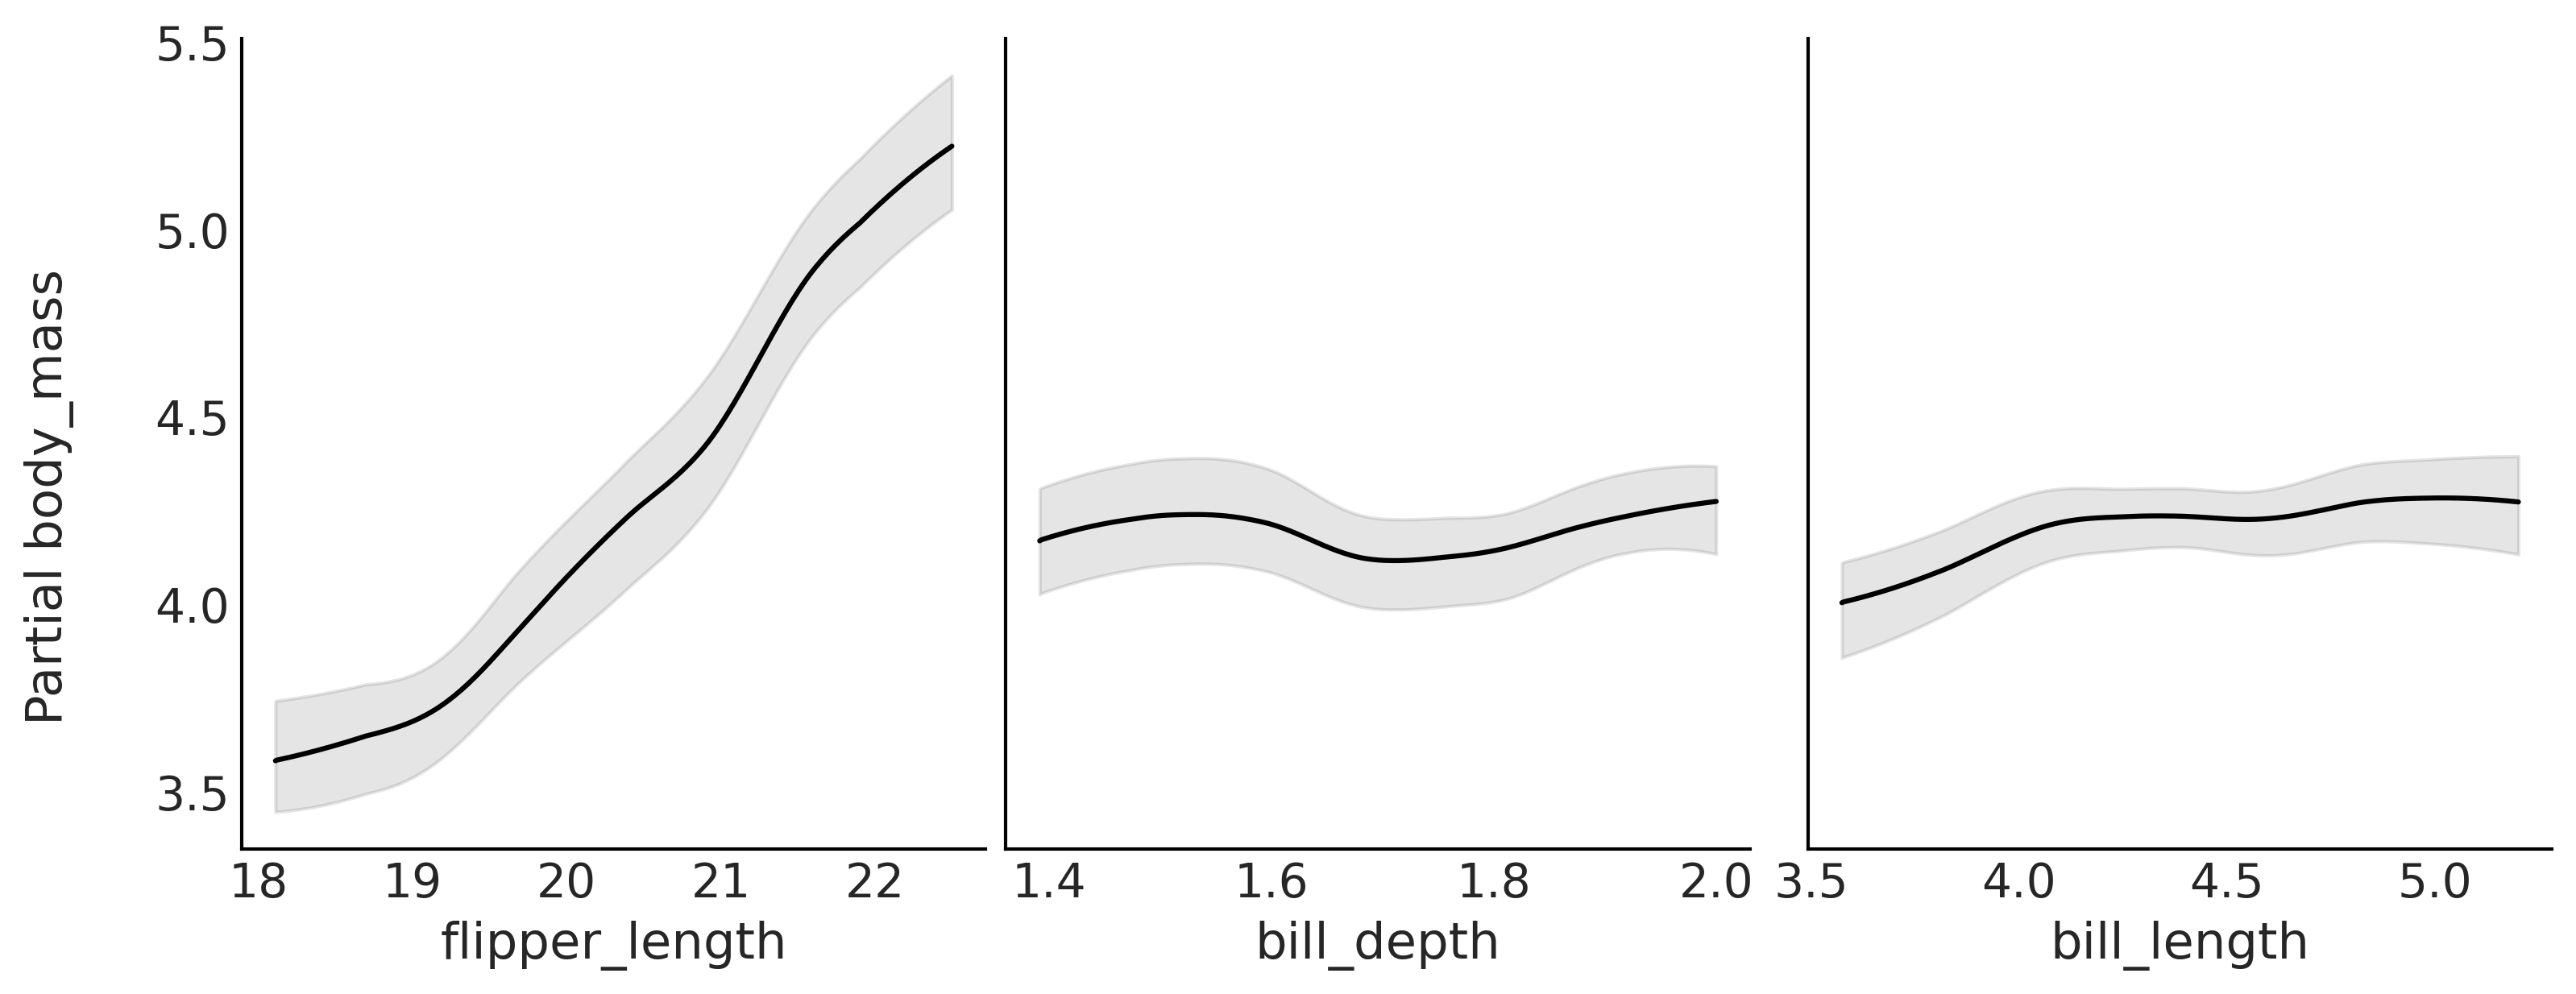

In [8]:
pmb.plot_pdp(μ, X, Y, grid=(1, 3), figsize=(10, 4))
plt.savefig("../fig/BART_pdp.png", bbox_inches="tight")

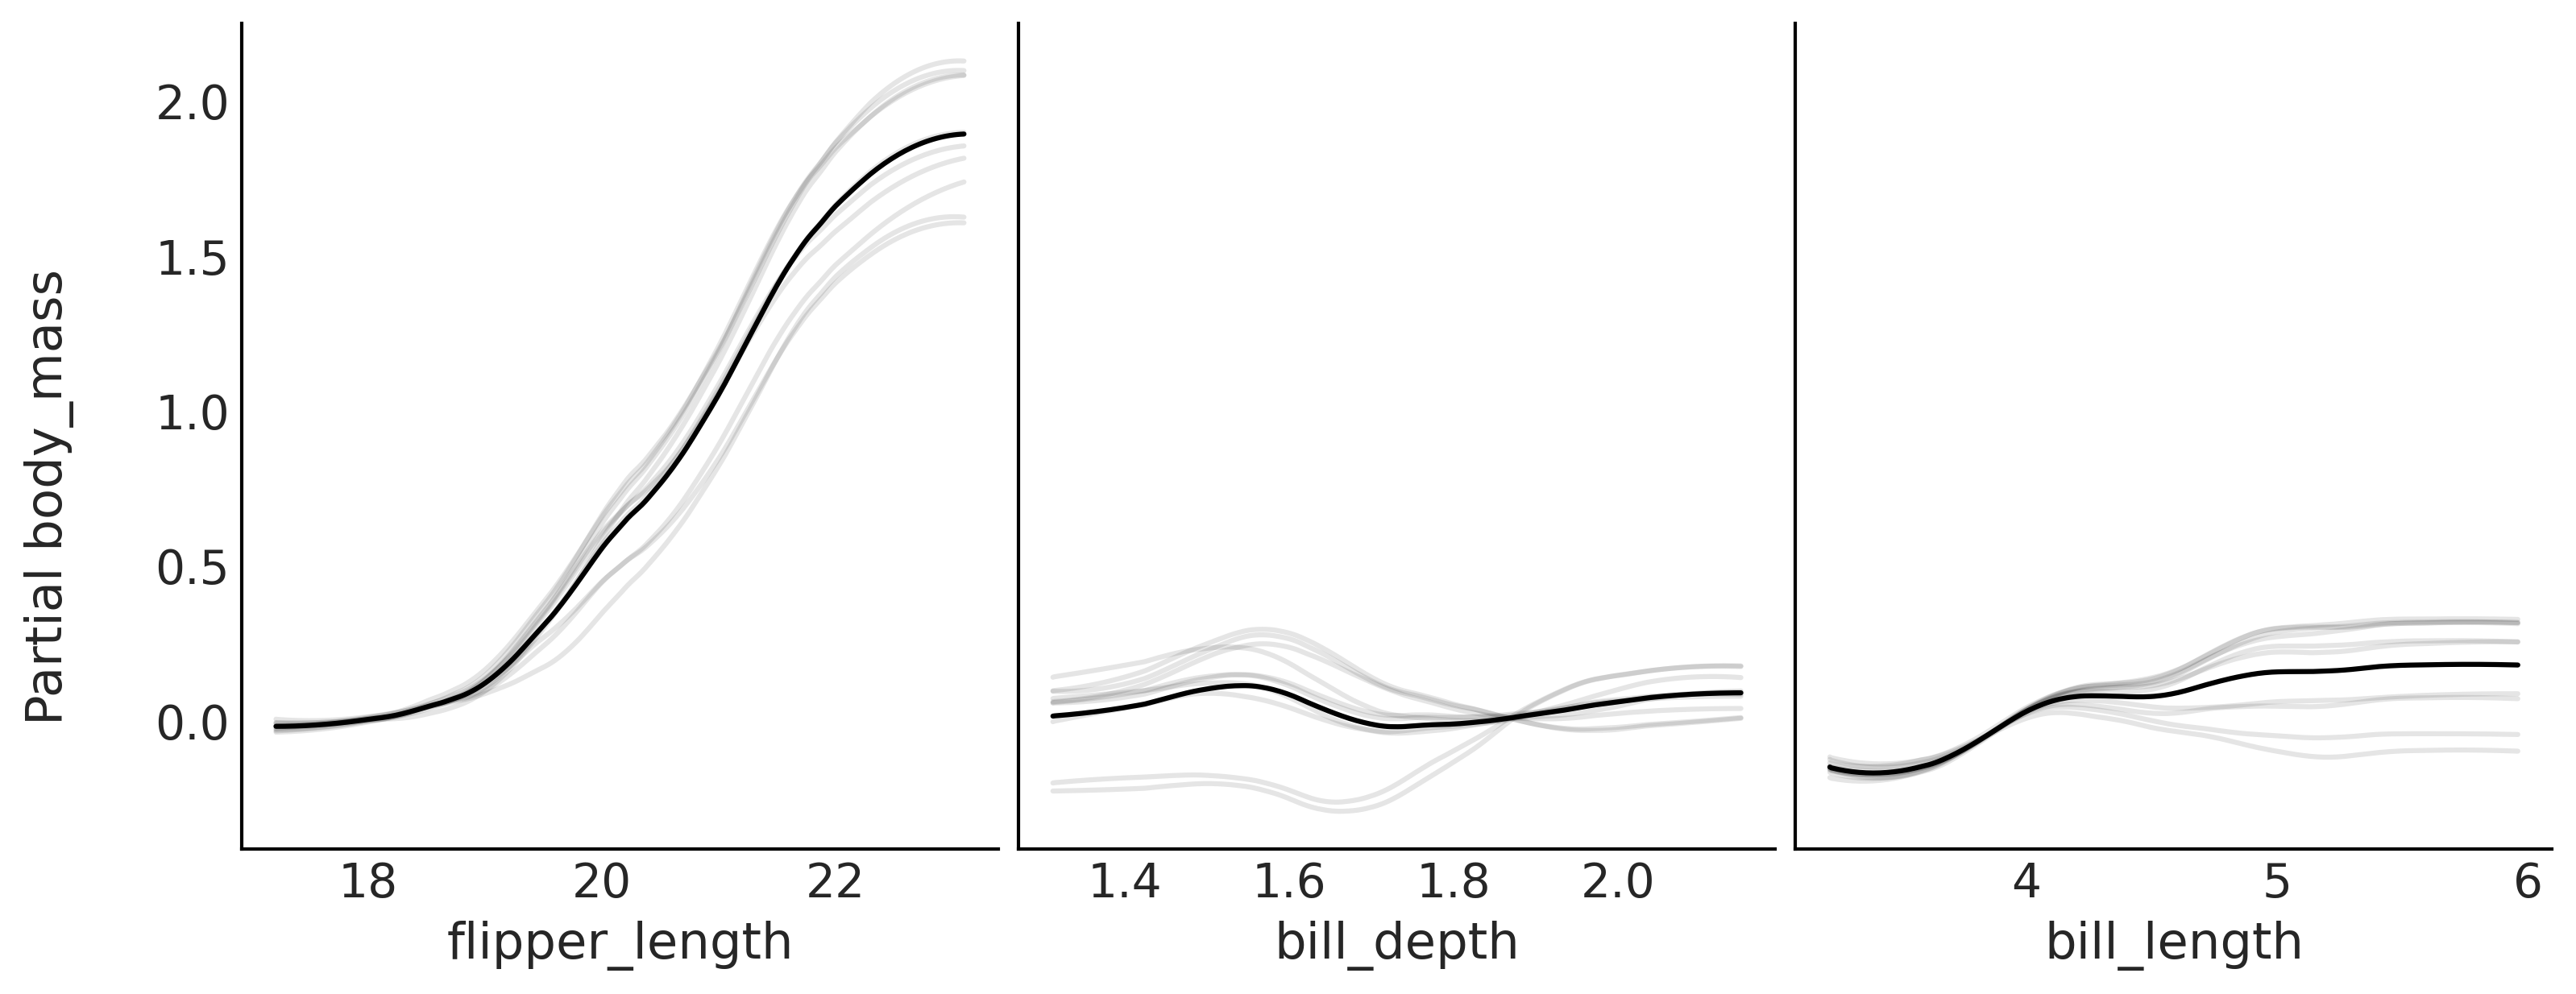

In [9]:
pmb.plot_ice(μ, X, Y, grid=(1, 3), figsize=(10, 4))
plt.savefig("../fig/BART_ice.png", bbox_inches="tight")

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pymc_bart/utils.py:786: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


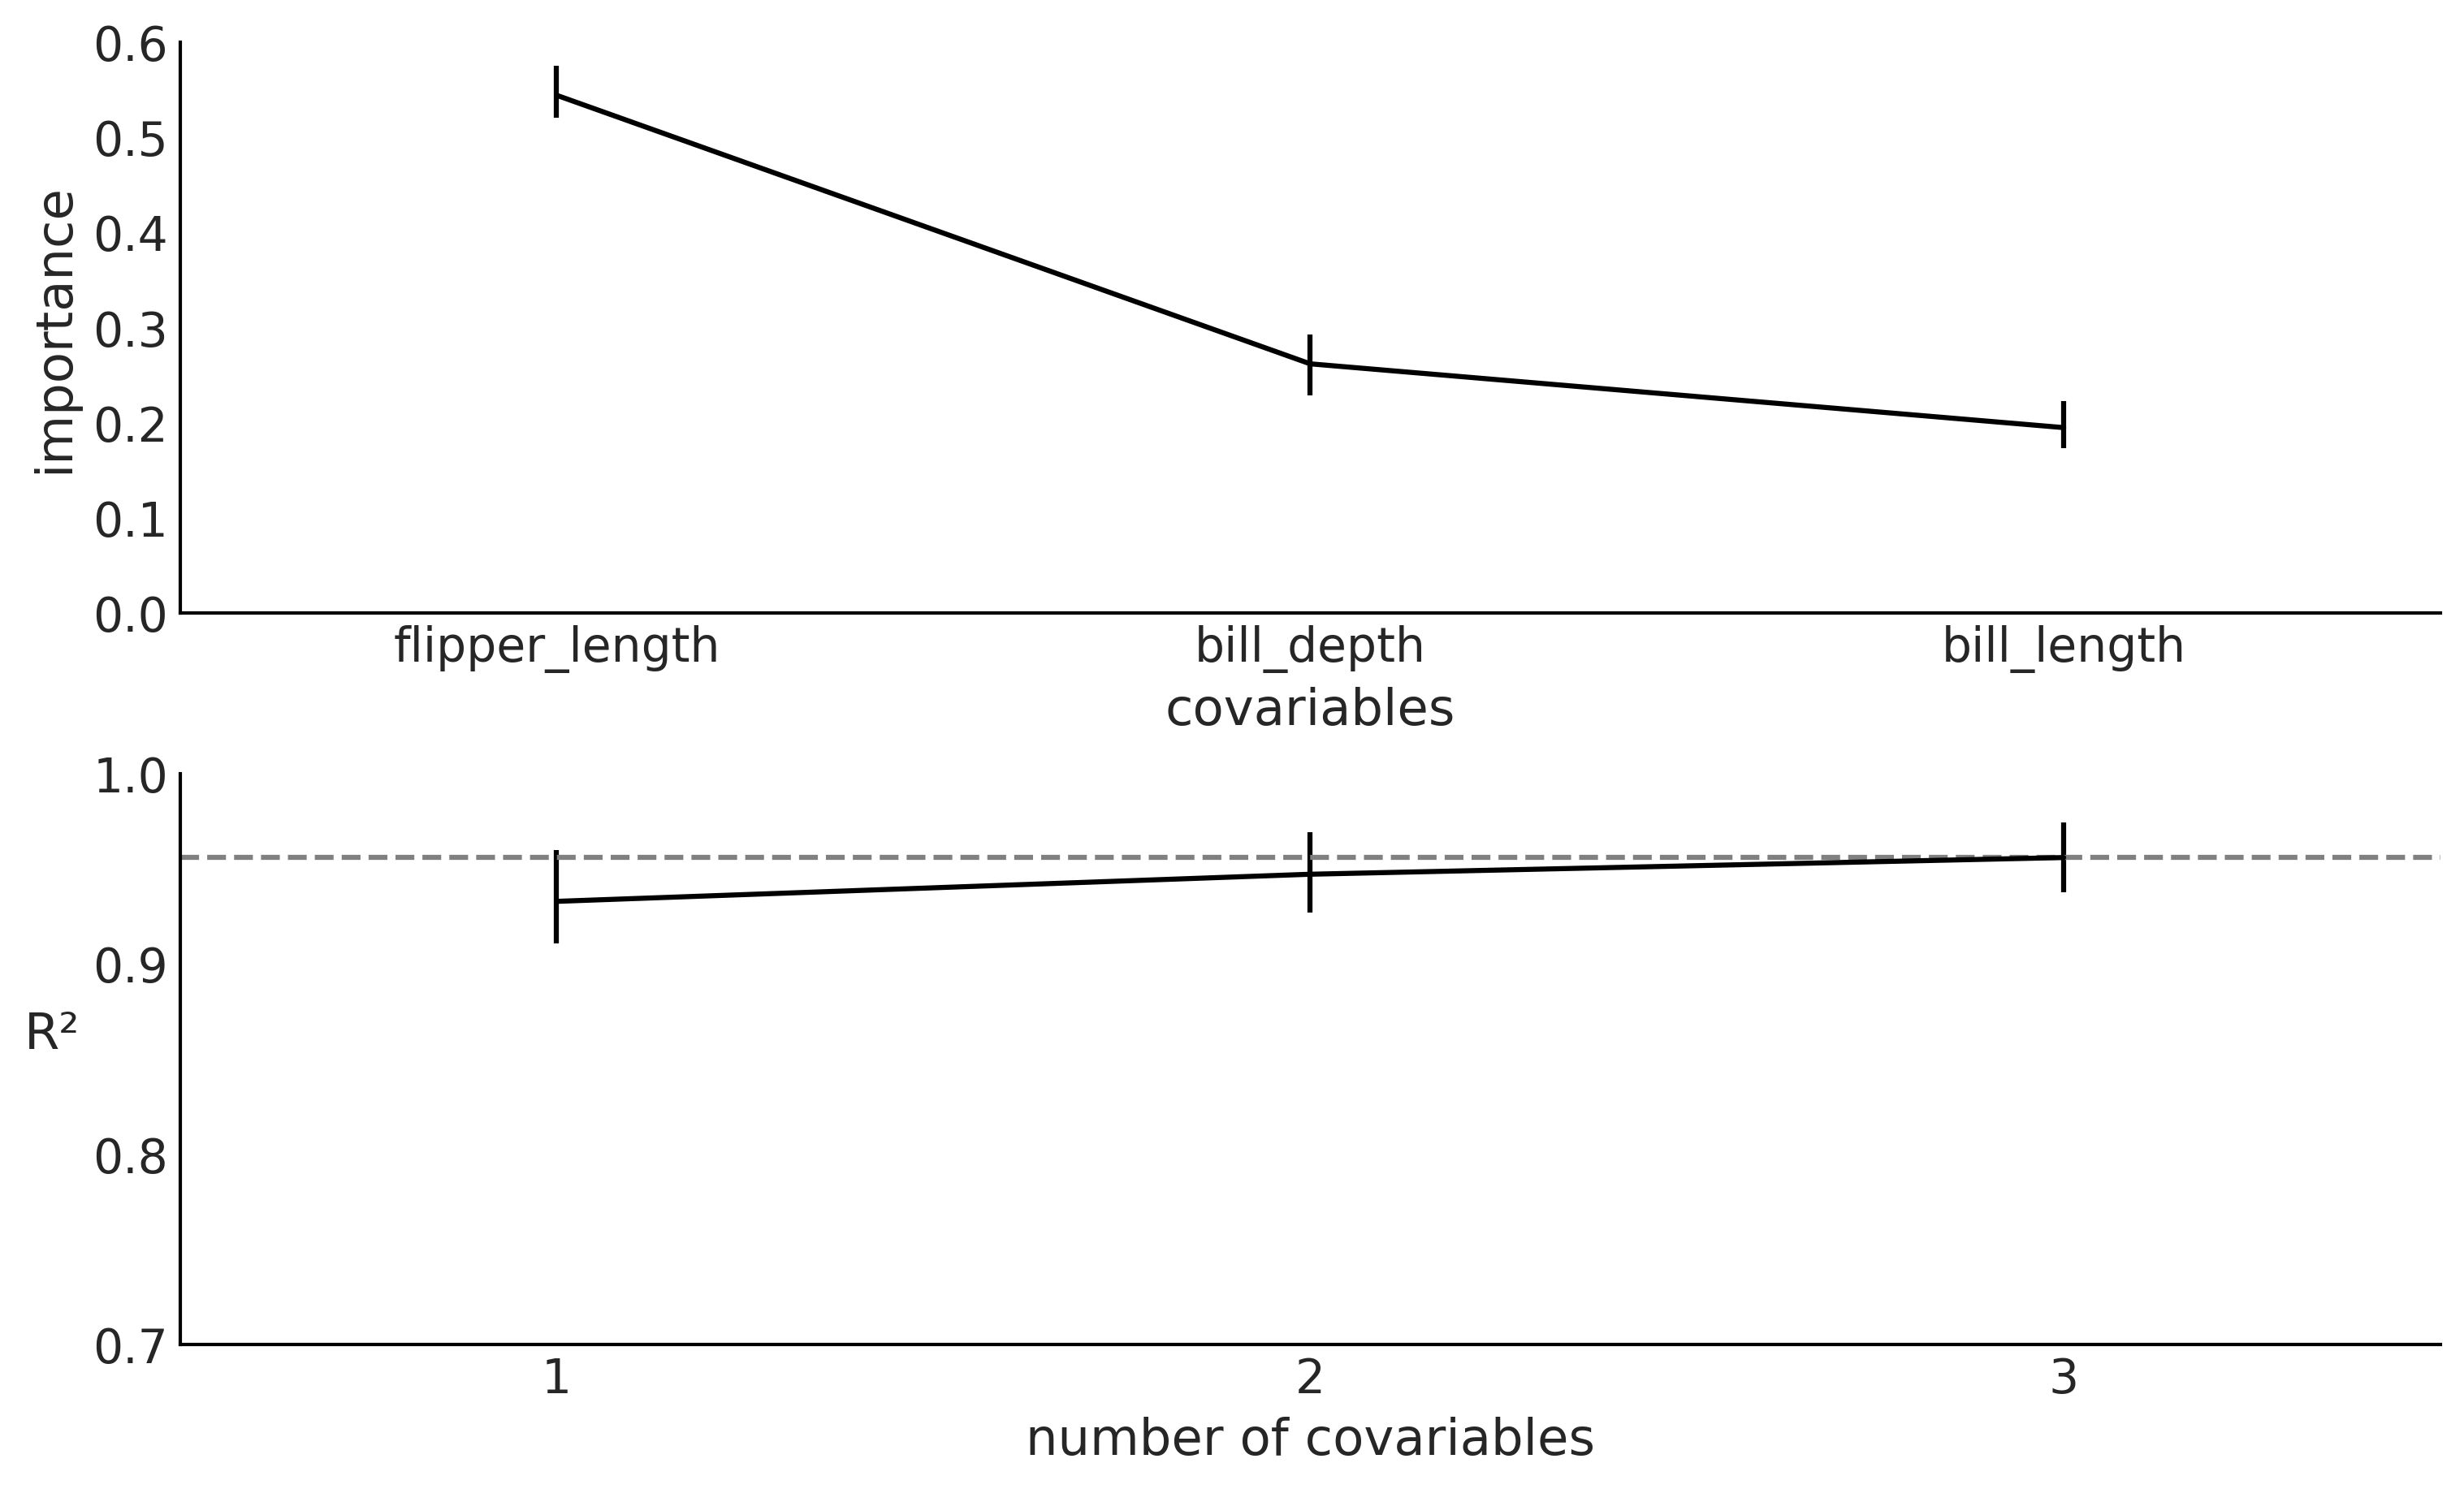

In [10]:
_, axes = pmb.plot_variable_importance(idata_pen, μ, X, figsize=(10, 6))
axes[0].set_ylim(0, .6)
axes[1].set_ylim(0.7, 1)
plt.savefig("../fig/BART_VI.png")

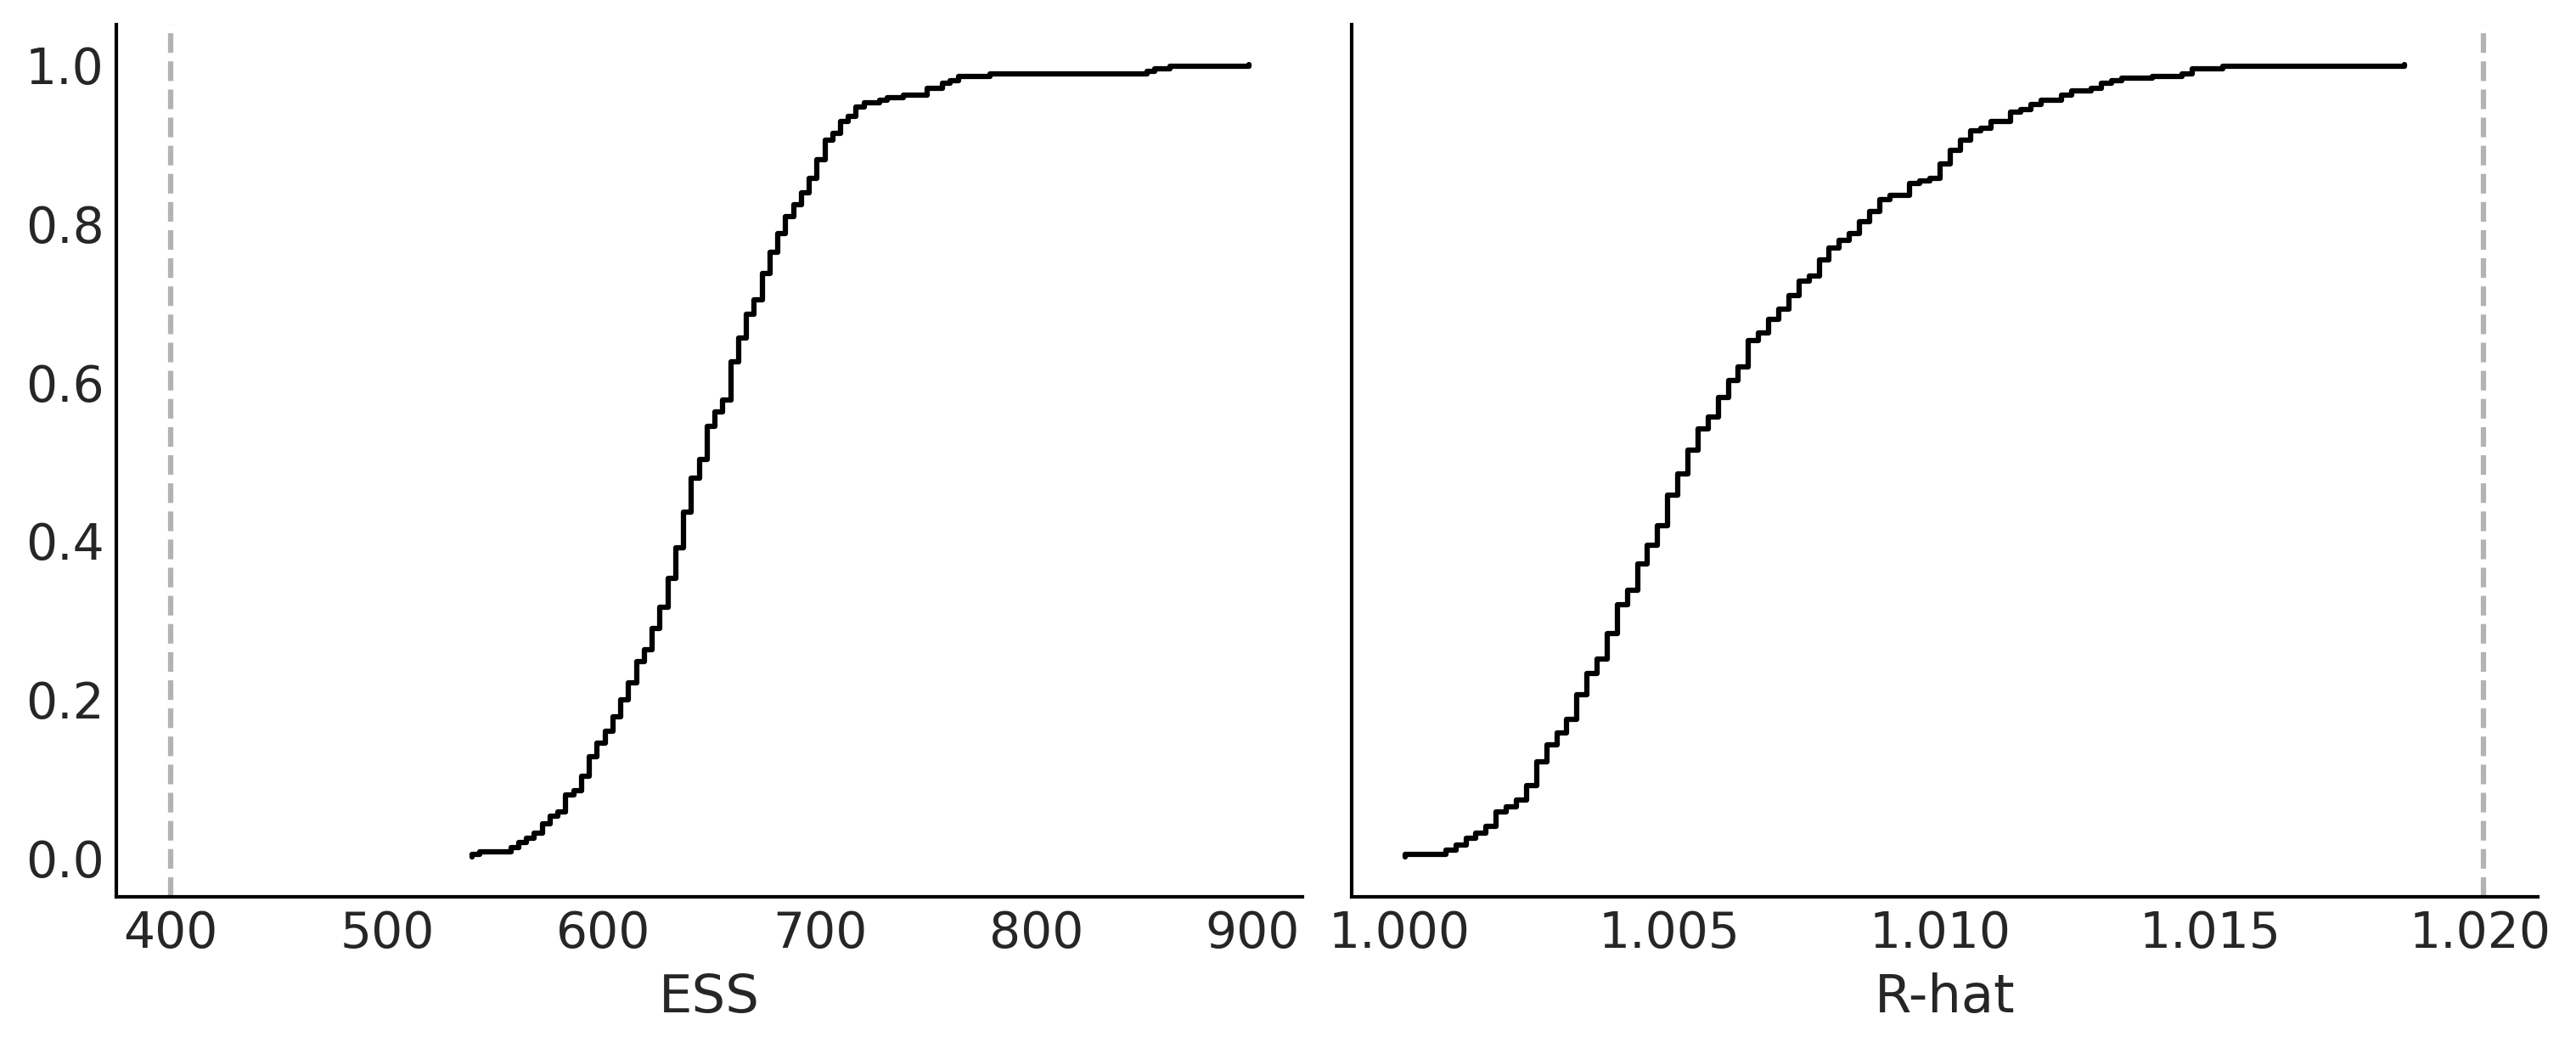

In [11]:
pmb.plot_convergence(idata_pen, var_name="μ", figsize=(10, 4))
plt.savefig("../fig/bart_plot_convergence.png")

## Constant vs linear responses

In [12]:
bikes = pd.read_csv("data/bikes.csv")
X = bikes["temperature"].values[:,None]
Y = bikes["rented"]

In [13]:
with pm.Model() as model_tmp0:
    X_mut0 = pm.MutableData("X_mut0", X)
    α = pm.HalfNormal('α', 1)
    μ = pmb.BART("μ", X_mut0, np.log(Y), m=100)
    _ = pm.NegativeBinomial('yl', np.exp(μ), α, observed=Y, shape=μ.shape)
    idata_tmp0 = pm.sample(random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


In [14]:
with pm.Model() as model_tmp1:
    X_mut1 = pm.MutableData("X_mut1", X)
    α = pm.HalfNormal('α', 1)
    μ = pmb.BART("μ", X_mut1, np.log(Y), m=100, response="linear")
    _ = pm.NegativeBinomial('yl', np.exp(μ), α, observed=Y, shape=μ.shape)
    idata_tmp1 = pm.sample(random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pymc_bart/bart.py:137: UserWarning: Options linear and mix are experimental and still not well tested
Use with caution.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


In [15]:
new_x = np.linspace(-20, 45, 100)
with model_tmp0:
    X_mut0.set_value(new_x[:,None])
    pp0 = pm.sample_posterior_predictive(idata_tmp0, random_seed=123)

Sampling: [yl, μ]


In [16]:
with model_tmp1:
    X_mut1.set_value(new_x[:,None])
    pp1 = pm.sample_posterior_predictive(idata_tmp1, random_seed=123)

Sampling: [yl, μ]


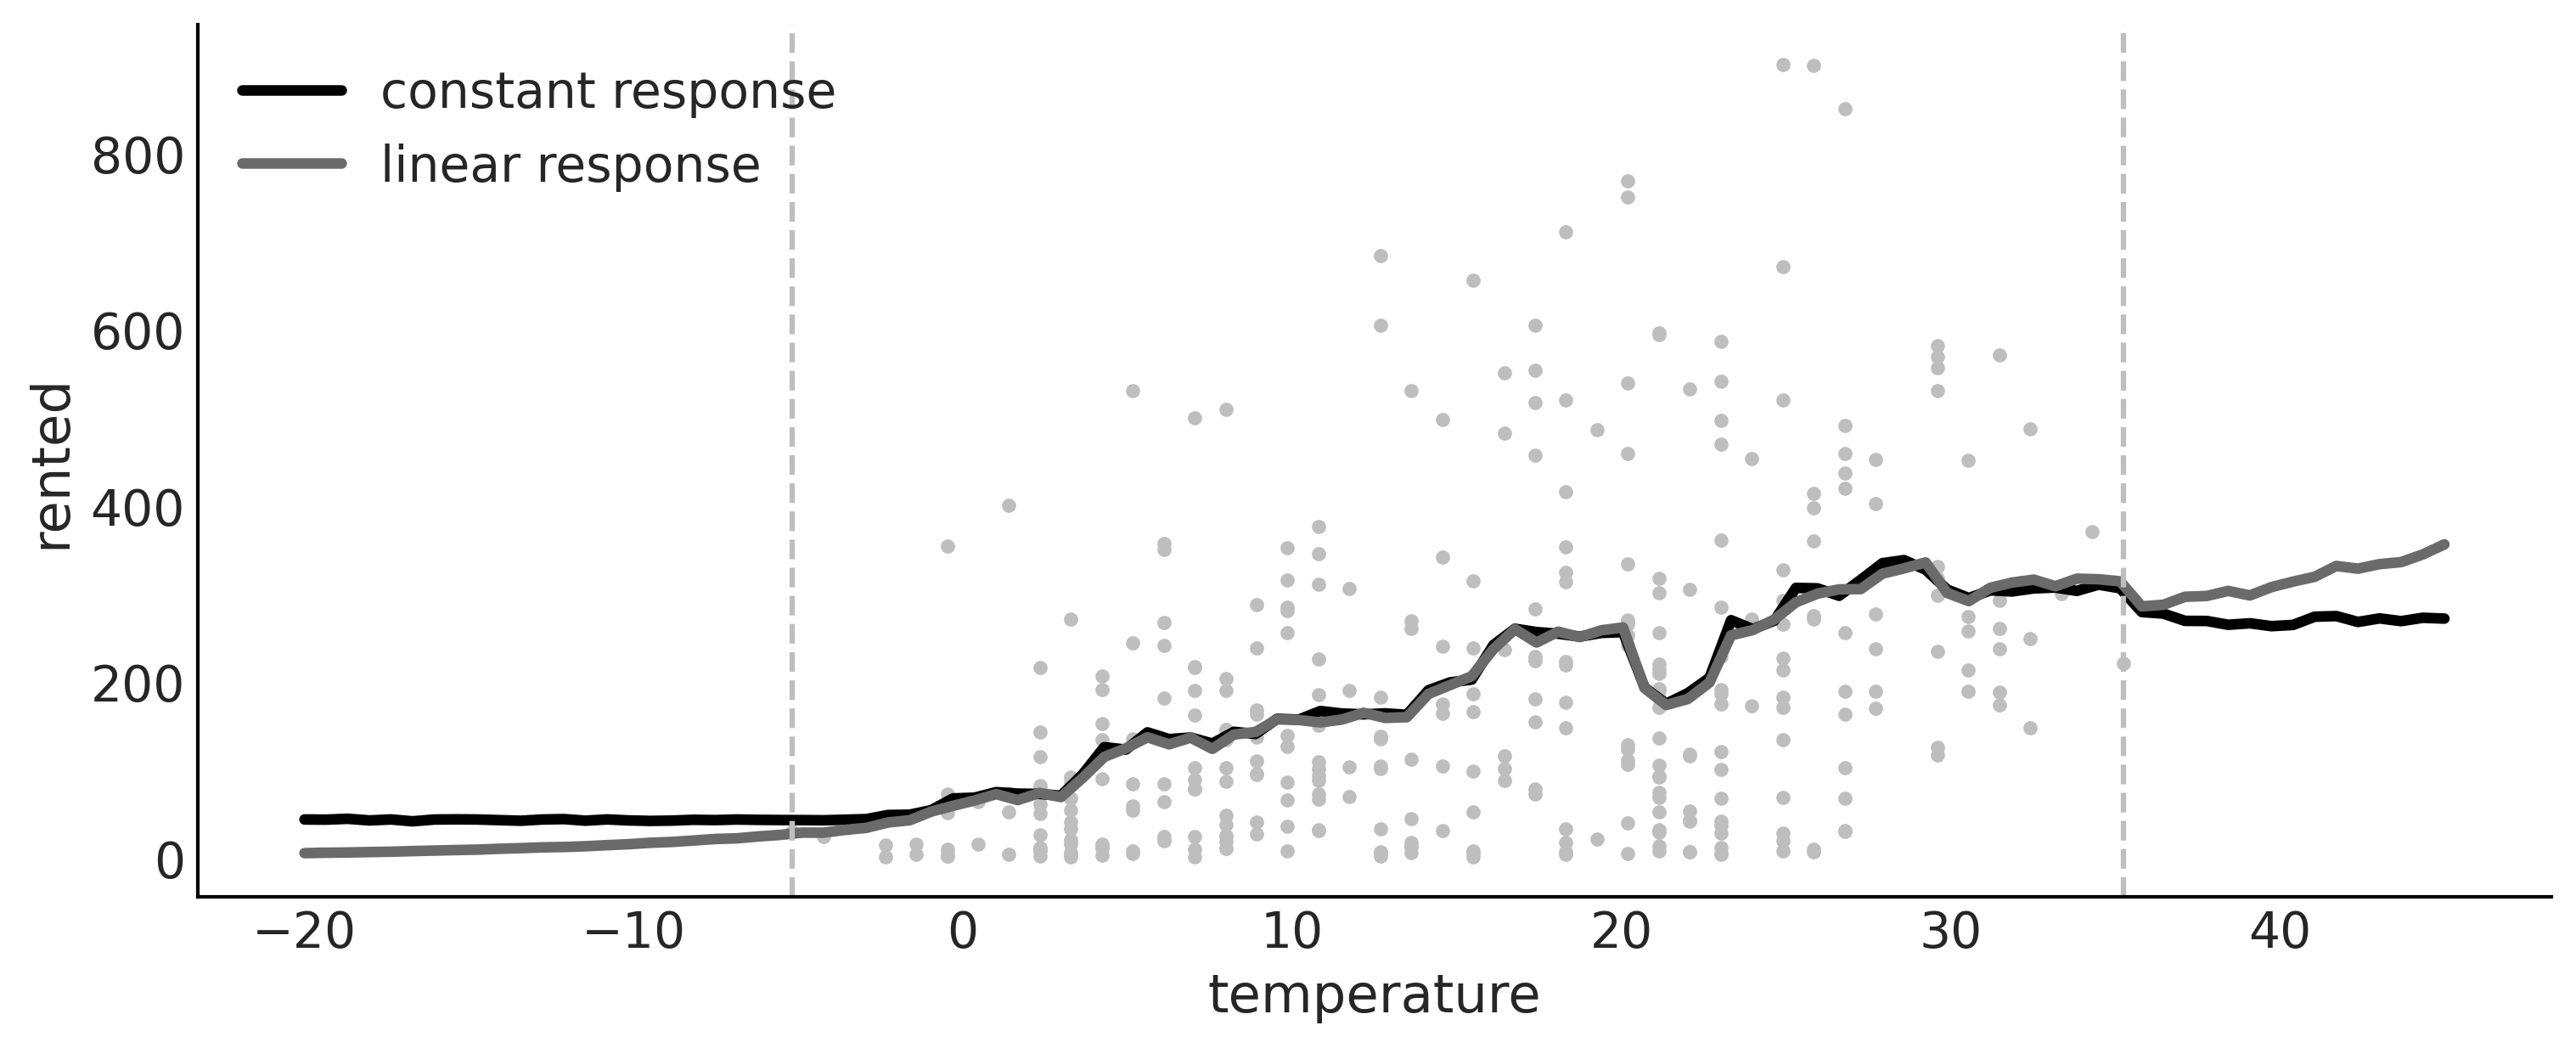

In [17]:
pred_y0 = pp0.posterior_predictive.mean(("chain", "draw"))["yl"]
pred_y1 = pp1.posterior_predictive.mean(("chain", "draw"))["yl"]


_, ax = plt.subplots(figsize=(10, 4))
ax.plot(new_x, pred_y0, color="C0", lw=3, label="constant response")
ax.plot(new_x, pred_y1, color="C1", lw=3, label="linear response")

ax.plot(X, Y, ".", color="C2", zorder=-1)
ax.axvline(X.min(), color="C2", linestyle="--")
ax.axvline(X.max(), color="C2", linestyle="--")

ax.set_xlabel("temperature")
ax.set_ylabel("rented")
plt.legend()
plt.savefig("../fig/BART_constant_vs_linear.png")

In [22]:
np.random.seed(123)
bikes = pd.read_csv("data/bikes.csv")
X = bikes[["hour", "temperature", "humidity", "weekday"]]
Y = bikes["rented"]
bikespaying attention to these adjustments becomes important.

SyntaxError: invalid syntax (4238588986.py, line 5)

In [23]:
with pm.Model() as model_bb:
    μ = pmb.BART("μ", X, np.log(Y), shape=(2, 348), separate_trees=True)
    pm.NegativeBinomial('yl', np.exp(μ[0]), np.exp(μ[1]), observed=Y)
    idata_bb = pm.sample(2000,
                         random_seed=123,
                         pgbart={"batch":(0.05, 0.15)})

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 168 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


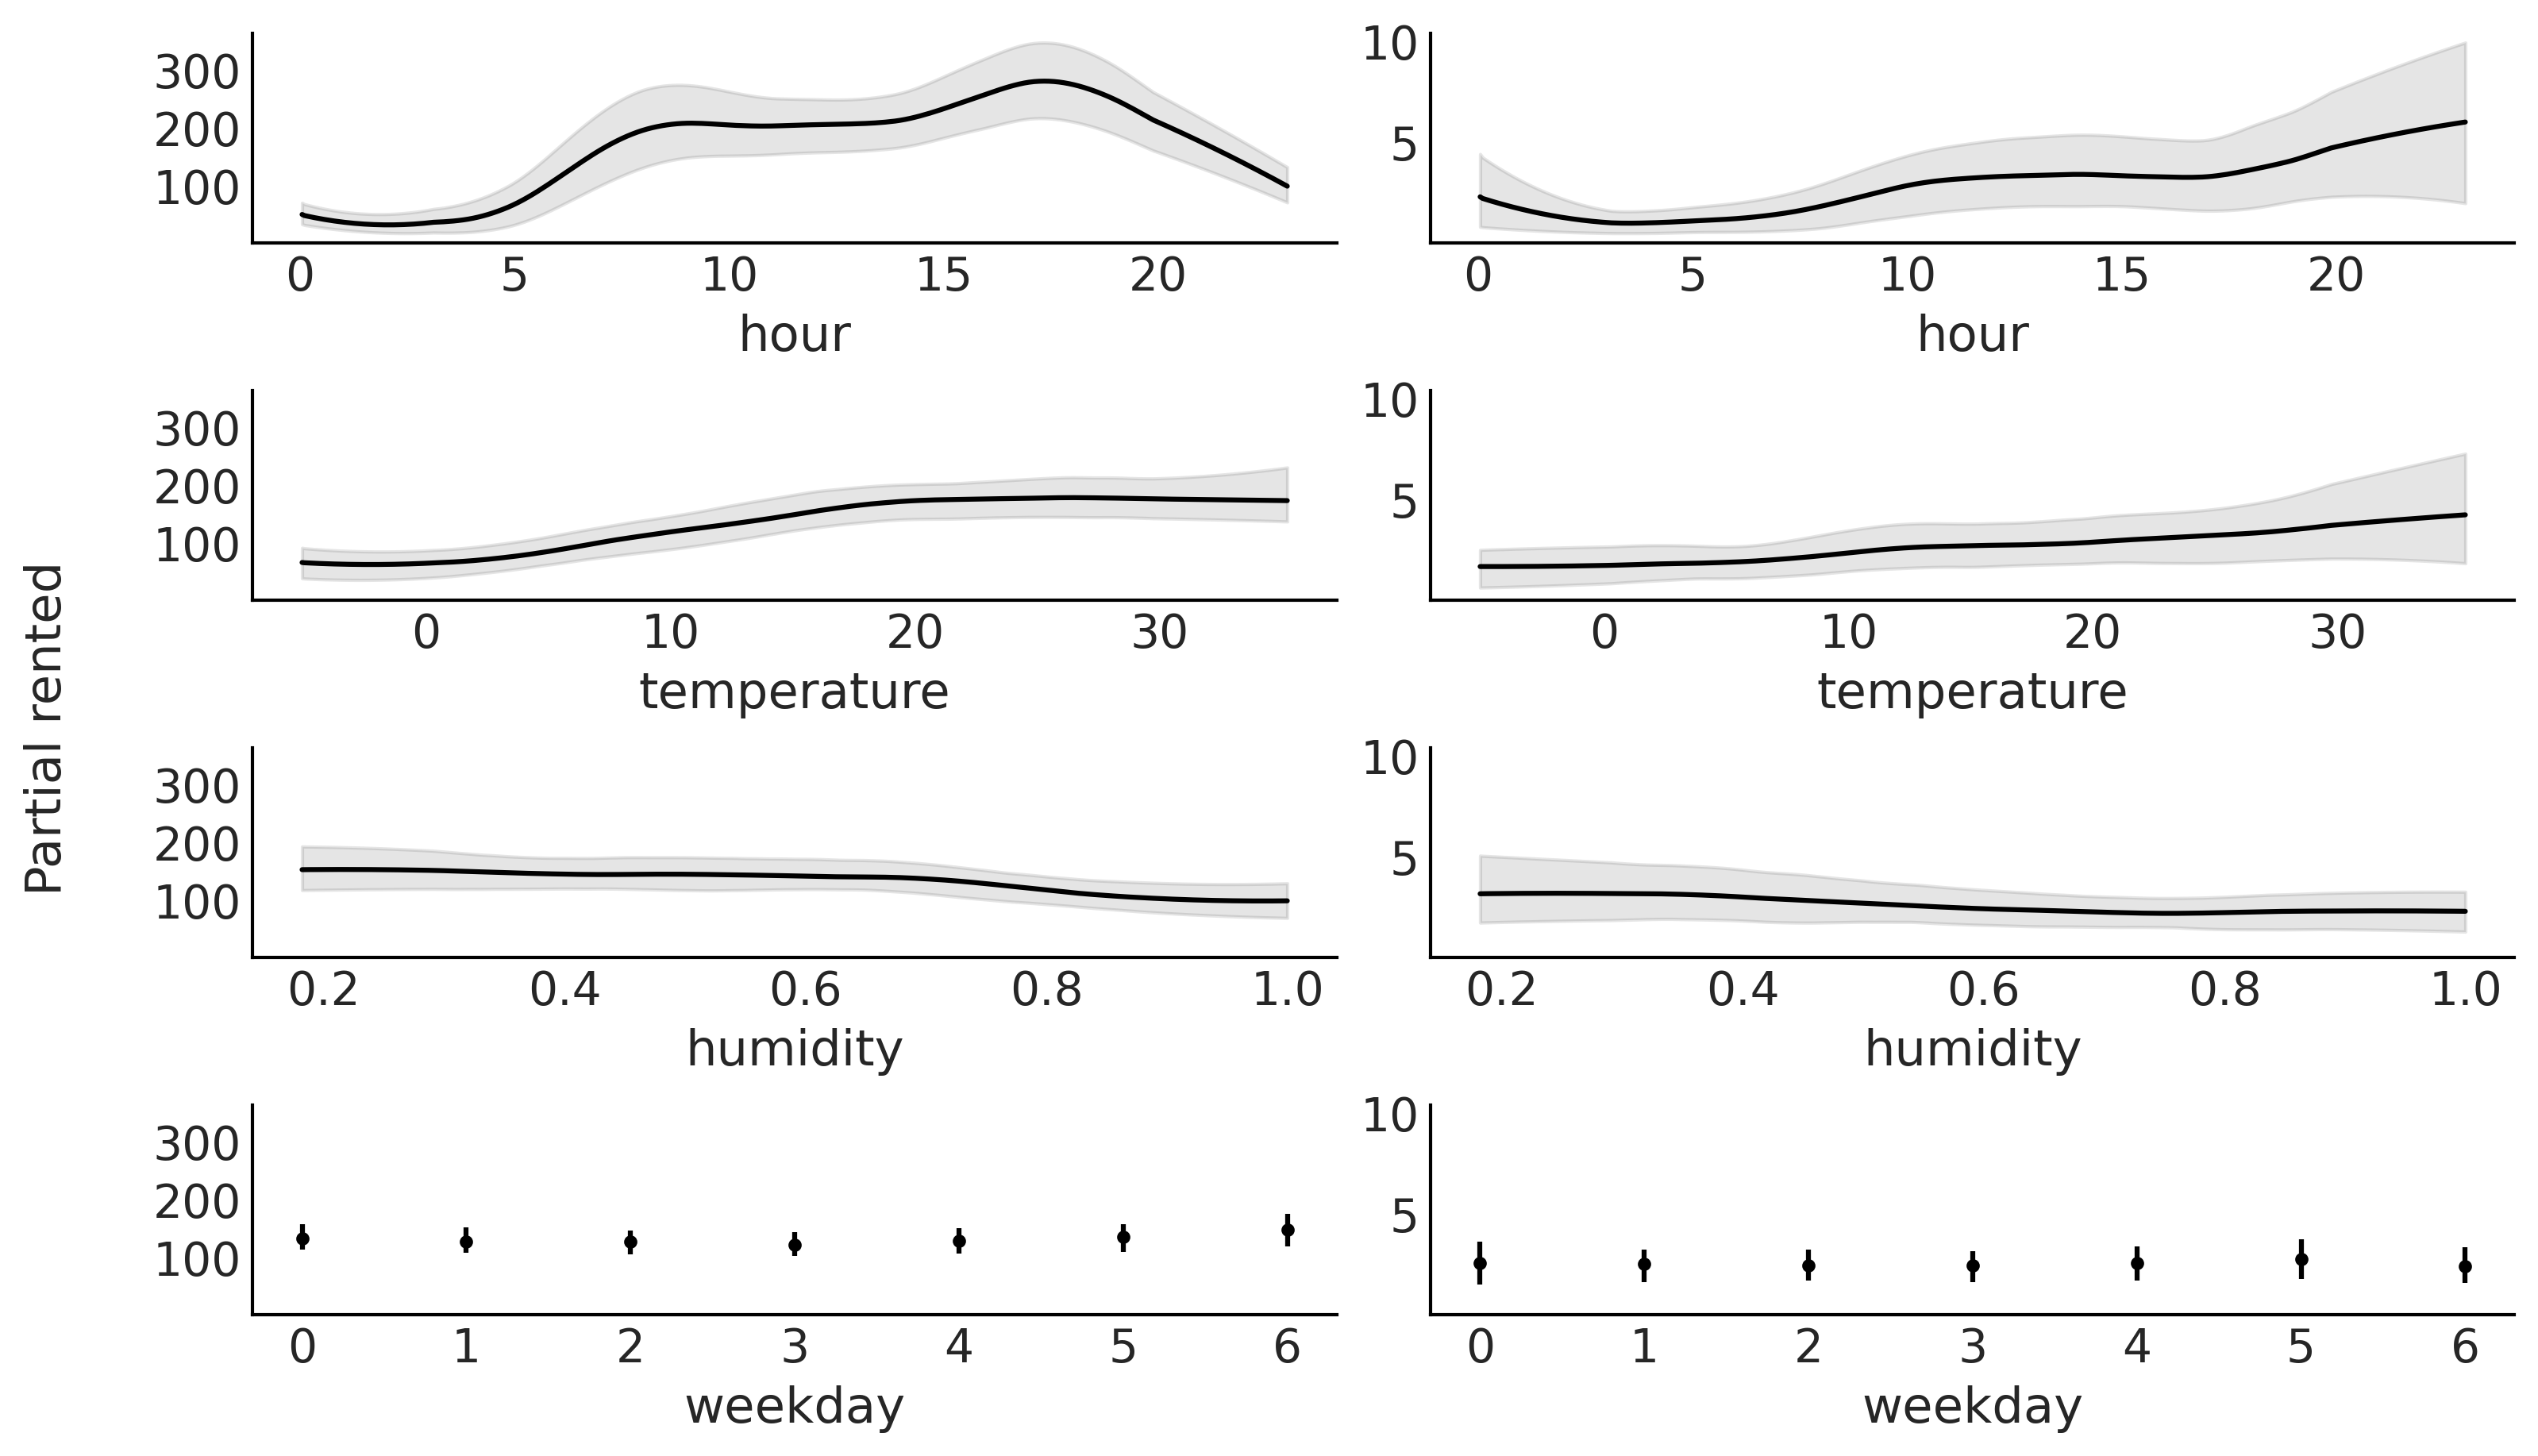

In [25]:
pmb.plot_pdp(μ, X, Y, xs_interval="insample", grid=(4, 2), sharey="col", figsize=(10, 6), func=np.exp , var_discrete=[3])
plt.savefig("../fig/BART_pdp_bikes.png", bbox_inches="tight")